In [ ]:
import rasterio as rio
from rasterio.plot import show
from osgeo import gdalconst
from osgeo import gdal
from osgeo_utils import gdal_calc
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from process_engine.oat import OAT
import pandas as pd

#### **Preparation**


In [3]:
# Constansts

# Image_to_attribute_Mapping
crit_dict = {
    "POPN": "population",
    "MARK": "market",
    "HLTH": "health",
    "ELEV": "elev",
    "SLOP": "slope",
    "LAND": "land_use",
    "RIVR": "river",
    "FLHZ": "flood_hazard",
    "ROADS": "road",
}

In [4]:
# Organise Image Files

data_folder = os.path.join(os.getcwd(), "raw_data", "normalised_raster_v2")
imgs = [os.path.join(data_folder, x)
        for x in os.listdir(data_folder) if x.endswith(".tif")]

target_img_dict = {}
for x, y in crit_dict.items():
    for path in imgs:
        if (path.find(y) == -1):
            continue

        if (x in target_img_dict):
            if (path.endswith('v2.tif')):
                target_img_dict[y] = path
        else:
            target_img_dict[y] = path

In [5]:
# Organise Weights
weights = {}
with open('ahp_report.json', 'r') as ahp_rep:
    data = json.load(ahp_rep)
    for x, y in crit_dict.items():
        for z in data['target_weights']:
            if (z.startswith(y)):
                weights[y] = data['target_weights'][z]

#### **Adjustment Matrices**


In [6]:
adjust_model = OAT(weights)
adjust_matrx = adjust_model.solve(100, -100, 25)

[-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]


In [31]:
# Load and Clean img matrices
def loadImgMatrix(url, band=1):
    output = {}
    with gdal.Open(url) as ds:
        array = ds.GetRasterBand(band).ReadAsArray()
        output['array'] = array
        output['bands'] = band
        output['proj'] = ds.GetProjection()
        output['transform'] = ds.GetGeoTransform()
        output['ysize'] = array.shape[0]
        output['xsize'] = array.shape[1]
        output

    return output


def cleanImgArray(input):
    array = input['array']
    nan_clean = np.where((array < 0), 0, array)
    input['array'] = nan_clean
    return input

cleaned_imgs = {}
 
for idx, url in target_img_dict.items():
    _loaded = loadImgMatrix(url)
    _cleaned = cleanImgArray(_loaded)
    cleaned_imgs[idx] = _cleaned


cleaned_imgs_arrs = {x:y['array'] for x, y in cleaned_imgs.items()}

In [ ]:
# loop adjust to imgs arrys
# criterion indeces
crit_idx = {x: y for x, y in enumerate(adjust_model.ids)}

CRITERION_INDEX = 0
MAIN_CRITERION = crit_idx[CRITERION_INDEX]

target_adjust_mtrx = adjust_matrx[CRITERION_INDEX]

array([[0.04325   , 0.0451188 , 0.11915992, 0.05784462, 0.03817745,
        0.03123609, 0.23137848, 0.25220254, 0.1816321 ],
       [0.0865    , 0.0430792 , 0.11377328, 0.05522975, 0.03645163,
        0.02982406, 0.22091898, 0.24080169, 0.1734214 ],
       [0.12975   , 0.0410396 , 0.10838664, 0.05261487, 0.03472582,
        0.02841203, 0.21045949, 0.22940085, 0.1652107 ],
       [0.173     , 0.039     , 0.103     , 0.05      , 0.033     ,
        0.027     , 0.2       , 0.218     , 0.157     ],
       [0.21625   , 0.0369604 , 0.09761336, 0.04738513, 0.03127418,
        0.02558797, 0.18954051, 0.20659915, 0.1487893 ],
       [0.2595    , 0.0349208 , 0.09222672, 0.04477025, 0.02954837,
        0.02417594, 0.17908102, 0.19519831, 0.1405786 ],
       [0.30275   , 0.0328812 , 0.08684008, 0.04215538, 0.02782255,
        0.02276391, 0.16862152, 0.18379746, 0.1323679 ]])

In [41]:
output = {}

for y, row in enumerate([-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]):
  _y_out = {}
  for x, col in enumerate(target_adjust_mtrx[y]):
    _y_out[crit_idx[x]] = cleaned_imgs_arrs[crit_idx[x]] * col
  
  output[row] = _y_out

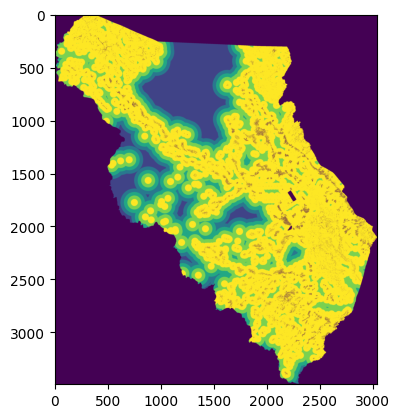

In [44]:
plt.figure()
plt.imshow(output[0.75][crit_dict['POPN']])

In [ ]:
gdal_calc.Calc()